<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Phyton_kriging:2D variogram </font>
</div>

- **Fecha**: 2023/06/15
        
- **Objetivos**:  Generación del variograma radial

- **Descripción** Para el variograma hace falta calcular las distancias entre los puntos 2D. Aquí se utiliza la funcion distance.cdist 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

- **Referencias**: -

- **Autores**: 
    - Luis Miguel Sánchez Brea

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [3]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 100


In [5]:
from phyton_kriging import np, plt

from phyton_kriging.variogram_2D import theoretical
from phyton_kriging.variogram_2D import experimental
from phyton_kriging.standard_2D import kriging2D


import scipy
from scipy.spatial import distance

from phyton_kriging.utils_math import nearest, nearest2

# Experimental function 



In [6]:
def f_signal(x, y, width=2, sc=0, I0=0, kind=0):
    """Simulation of data

    Args:
        x (np.array): x_positions
        y (np.array): y_positions
        width (flaot): width of gauss function
        sc (float or np.array): random noise
        I0 (float or np.array): detector precision

    Returns:
        y (np.array): data.
    """
    

    match kind:
        case 0:
            z = x + y
        case 1:
            z = np.sin(2 * np.pi * x / 1) * np.sin(2 * np.pi * y / 1) + x / 20
        case 2:
            z = np.sin(2 * np.pi * x / 0.5)
        case 3:
            z = 5*np.exp(-(x**2 + y**2) / (2*width**2))
        case 4:
            z = np.cos(2 * np.pi * np.sqrt(x**2+y**2) / 1) 


    z = z + sc * np.random.randn(*z.shape)
    z = z + 2 * I0 * (np.random.rand(*z.shape) - 0.5)

    return z

In [7]:
def variogram_2D_radial(sensors, h_var, remove_origin=True, has_draw=True):
    """
    """
    num_sensors=len(sensors)

    positions = np.zeros((num_sensors, 2), dtype=float)
    positions[:, 0] = sensors[:,0]
    positions[:, 1] = sensors[:,1]
    

    
    i_var = np.arange(0,len(h_var))
    variogram = np.zeros_like(i_var, dtype=float)   
    num_data = np.zeros_like(i_var, dtype=float)   

    d0 = distance.cdist(positions, positions, 'euclidean')
    print(d0.max())

    i_distances, _, _ = nearest2(h_var,d0)

    # i_distances = i_distances.astype(dtype=float)
    # i_distances[np.tril_indices(i_distances.shape[0], -1)] = np.nan

    # elimina el triángulo inferior de la matriz de distancias para no contarlo 2 veces.
    d0[np.tril_indices(d0.shape[0], -1)] = np.nan

    
    for i_h, k in enumerate(i_var):

        has_condition_distance = i_distances == i_h

        x_true, y_true = np.where(has_condition_distance)


        n_data = (has_condition_distance).sum()
        num_data[k] = n_data
        
        if n_data!=0:
            variogram_j = ((sensors[x_true,2]-sensors[y_true,2])**2).sum()/(2*n_data)
        else:
            variogram_j = None
        
        variogram[k]= variogram_j
    
    if remove_origin:
        variogram[1]=variogram[0]
    
    if has_draw:
        plt.figure
        plt.plot(h_var, np.sqrt(variogram),'ko')
        plt.xlim(0)
        plt.ylim(0)
        plt.title("$s_c$ = {:2.2f}".format(sc))
        
    return variogram, num_data

In [8]:
h_var = np.linspace(0,2,51)
print(h_var)

[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96 1.   1.04 1.08
 1.12 1.16 1.2  1.24 1.28 1.32 1.36 1.4  1.44 1.48 1.52 1.56 1.6  1.64
 1.68 1.72 1.76 1.8  1.84 1.88 1.92 1.96 2.  ]


In [18]:
sc = .5
I0 = .0001
width = 2

num_x = num_y = 10
num_sensors = num_x * num_y

sensors = np.zeros((num_sensors, 4), dtype=float)
positions = np.zeros((num_sensors, 2), dtype=float)


x = -5 + 10 * np.random.rand(num_sensors)
y = -5 + 10 * np.random.rand(num_sensors)

sensors[:, 0] = x
sensors[:, 1] = y
sensors[:, 2] = f_signal(x, y, width, sc, I0, kind=1)
sensors[:, 3] = I0 * np.ones_like(x)

#sensors[:, 2] = sensors[:, 2] + sensors[:, 3] * np.random.randn(num_sensors)
positions = np.zeros((num_sensors, 2), dtype=float)

positions[:, 0] = x
positions[:, 1] = y


12.301085971236141


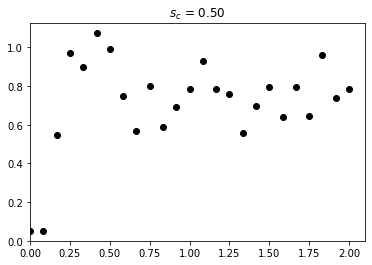

In [19]:
variogram, num_data = variogram_2D_radial(sensors, h_var, has_draw=True)

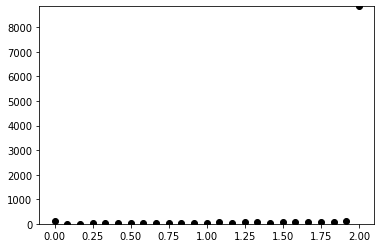

In [20]:
plt.plot(h_var, num_data, 'ko')
plt.ylim(0,num_data.max())

In [21]:
h_var = np.linspace(0,2,25)
print(h_var)

[0.     0.0833 0.1667 0.25   0.3333 0.4167 0.5    0.5833 0.6667 0.75
 0.8333 0.9167 1.     1.0833 1.1667 1.25   1.3333 1.4167 1.5    1.5833
 1.6667 1.75   1.8333 1.9167 2.    ]


In [31]:
sc = .5
I0 = .0001
width = 2

num_x = num_y = 50
num_sensors = num_x * num_y

sensors = np.zeros((num_sensors, 4), dtype=float)
positions = np.zeros((num_sensors, 2), dtype=float)


x = np.linspace(-2, 2, num_x)
y = np.linspace(-2, 2, num_y)

X, Y = np.meshgrid(x, y)
x = X.flatten()
y = Y.flatten()


sensors[:, 0] = x
sensors[:, 1] = y
sensors[:, 2] = f_signal(x, y, width, sc, I0, kind=3)
sensors[:, 3] = I0 * np.ones_like(x)

#sensors[:, 2] = sensors[:, 2] + sensors[:, 3] * np.random.randn(num_sensors)
positions = np.zeros((num_sensors, 2), dtype=float)

positions[:, 0] = x
positions[:, 1] = y

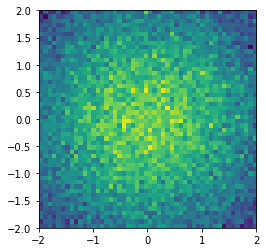

In [33]:
# X,Y = np.meshgrid(x,y)
image_Z = f_signal(X,Y, width, sc, I0, kind=3)

plt.imshow(image_Z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')

5.656854249492381


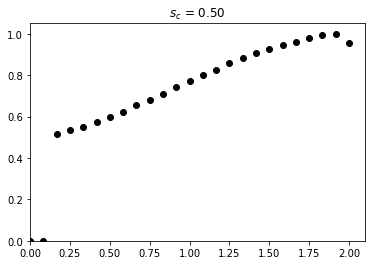

In [34]:
variogram, num_data = variogram_2D_radial(sensors, h_var, has_draw=True)

In [35]:
max_ordered=num_data.sort()
print(max_ordered)

None


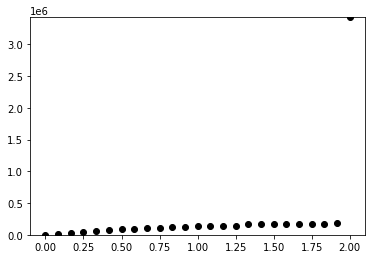

In [36]:
plt.plot(h_var, num_data, 'ko')
plt.ylim(0,num_data.max())